In [1]:
import util
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

In [2]:
#constants
PERCENT_OF_DATA = 0.0125
NUM_ENSEMBLE_MODELS = 3

num_classes = 2
model_save_path = "models/deepfake_detector_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saliency_partitioned_save_path = "PartitionedDataset/"

# Training ResNet-18 Model

In [ ]:
# load data
train_subset = util.load_data.get_subset('Train', data_percentage=PERCENT_OF_DATA)
test_subset = util.load_data.get_subset('Test', data_percentage=PERCENT_OF_DATA)
validation_subset = util.load_data.get_subset('Validation', data_percentage=PERCENT_OF_DATA)

train_loader = util.load_data.load_dataset(train_subset, batch_size=32)
test_loader = util.load_data.load_dataset(test_subset, batch_size=32)
validation_loader = util.load_data.load_dataset(validation_subset, batch_size=32)

In [ ]:
model = util.dfnn_model.DeepfakeDetectorCNN(num_classes=num_classes)

# Example training setup
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
util.train_model.train_with_validation(model, train_loader, validation_loader, criterion, optimizer, device)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [03:00<00:00,  3.28s/it]


Training Loss: 0.4030
Validation Loss: 0.3451, Validation Accuracy: 89.02%

Epoch [2/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [02:58<00:00,  3.25s/it]


Training Loss: 0.2294
Validation Loss: 0.3295, Validation Accuracy: 87.40%

Epoch [3/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [03:14<00:00,  3.55s/it]


Training Loss: 0.1687
Validation Loss: 0.4390, Validation Accuracy: 83.74%

Epoch [4/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [03:10<00:00,  3.47s/it]


Training Loss: 0.1327
Validation Loss: 0.9507, Validation Accuracy: 72.56%

Epoch [5/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [03:40<00:00,  4.01s/it]


Training Loss: 0.1379
Validation Loss: 0.4112, Validation Accuracy: 85.16%

Epoch [6/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [03:35<00:00,  3.92s/it]


Training Loss: 0.0982
Validation Loss: 0.2368, Validation Accuracy: 91.26%

Epoch [7/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Training Loss: 0.1124
Validation Loss: 0.2300, Validation Accuracy: 90.24%

Epoch [8/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Training Loss: 0.0582
Validation Loss: 0.3681, Validation Accuracy: 88.62%

Epoch [9/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [03:04<00:00,  3.36s/it]


Training Loss: 0.0400
Validation Loss: 0.6391, Validation Accuracy: 84.76%

Epoch [10/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [03:06<00:00,  3.39s/it]


Training Loss: 0.0622
Validation Loss: 0.3141, Validation Accuracy: 87.80%



In [11]:
test_loss, test_accuracy = util.train_model.test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")

Test Loss: 0.2628, Test Accuracy: 84.56%



In [12]:
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to models/deepfake_detector_model.pth


# Disjoint Ensembles Against Adversarial Examples

## Creating Images/Subsets

In [7]:
# create folder for subset of data
util.subset_data.create_subset_from_existing_dataset("Deepfake_Dataset/", "Subset_Dataset/", PERCENT_OF_DATA/4)

Subset dataset created at Subset_Dataset/


In [4]:
def partition_and_save_images(dataset_path, save_path):
    for class_name in ['Real', 'Fake']:
        class_folder = os.path.join(dataset_path, class_name)
        img_list = os.listdir(class_folder)

        print(f"Processing class: {class_name}")
        for img_name in tqdm(img_list, desc=f"Partitioning {class_name}", unit="image"):
            img_path = os.path.join(class_folder, img_name)
            image = util.saliency_partitioning.load_image(img_path)
            partitions = util.saliency_partitioning.partition_image_for_ensemble(model, image)
            
            for partition_idx, partition in enumerate(partitions):
                partition = np.clip(partition, 0, 255).astype(np.uint8)
                partition_folder = os.path.join(save_path, f"Partition{partition_idx + 1}", class_name)
                os.makedirs(partition_folder, exist_ok=True)
                partition_image_path = os.path.join(partition_folder, img_name)
                im = Image.fromarray(partition, 'RGB')
                im.save(partition_image_path)

# Example: Partition and save images
partition_and_save_images('Subset_Dataset/Train', save_path='PartitionedDataset/Train')
partition_and_save_images('Subset_Dataset/Validation', save_path='PartitionedDataset/Validation')
partition_and_save_images('Subset_Dataset/Test', save_path='PartitionedDataset/Test')

Processing class: Real


Partitioning Real:   0%|                                                                                           | 0/218 [00:00<?, ?image/s]


NameError: name 'model' is not defined

In [6]:
fake_image = util.saliency_partitioning.load_image("Deepfake_Dataset/Test/Fake/fake_15.jpg")
fake_partitions = util.saliency_partitioning.partition_image_for_ensemble(single_model, fake_image, num_models=5, num_bands=20, attack_steps=10, epsilon=0.01, device='cpu', attack_type = "cw")

Binary Search Iterations: 100%|███████████████████████████████████████| 5/5 [00:07<00:00,  1.52s/it]


In [8]:
real_image = util.saliency_partitioning.load_image("Deepfake_Dataset/Test/Real/real_1170.jpg")
real_partitions = util.saliency_partitioning.partition_image_for_ensemble(single_model, real_image, num_models=5, num_bands=20, attack_steps=10, epsilon=0.01, device='cpu', attack_type = "cw")

Binary Search Iterations: 100%|███████████████████████████████████████| 5/5 [00:07<00:00,  1.52s/it]


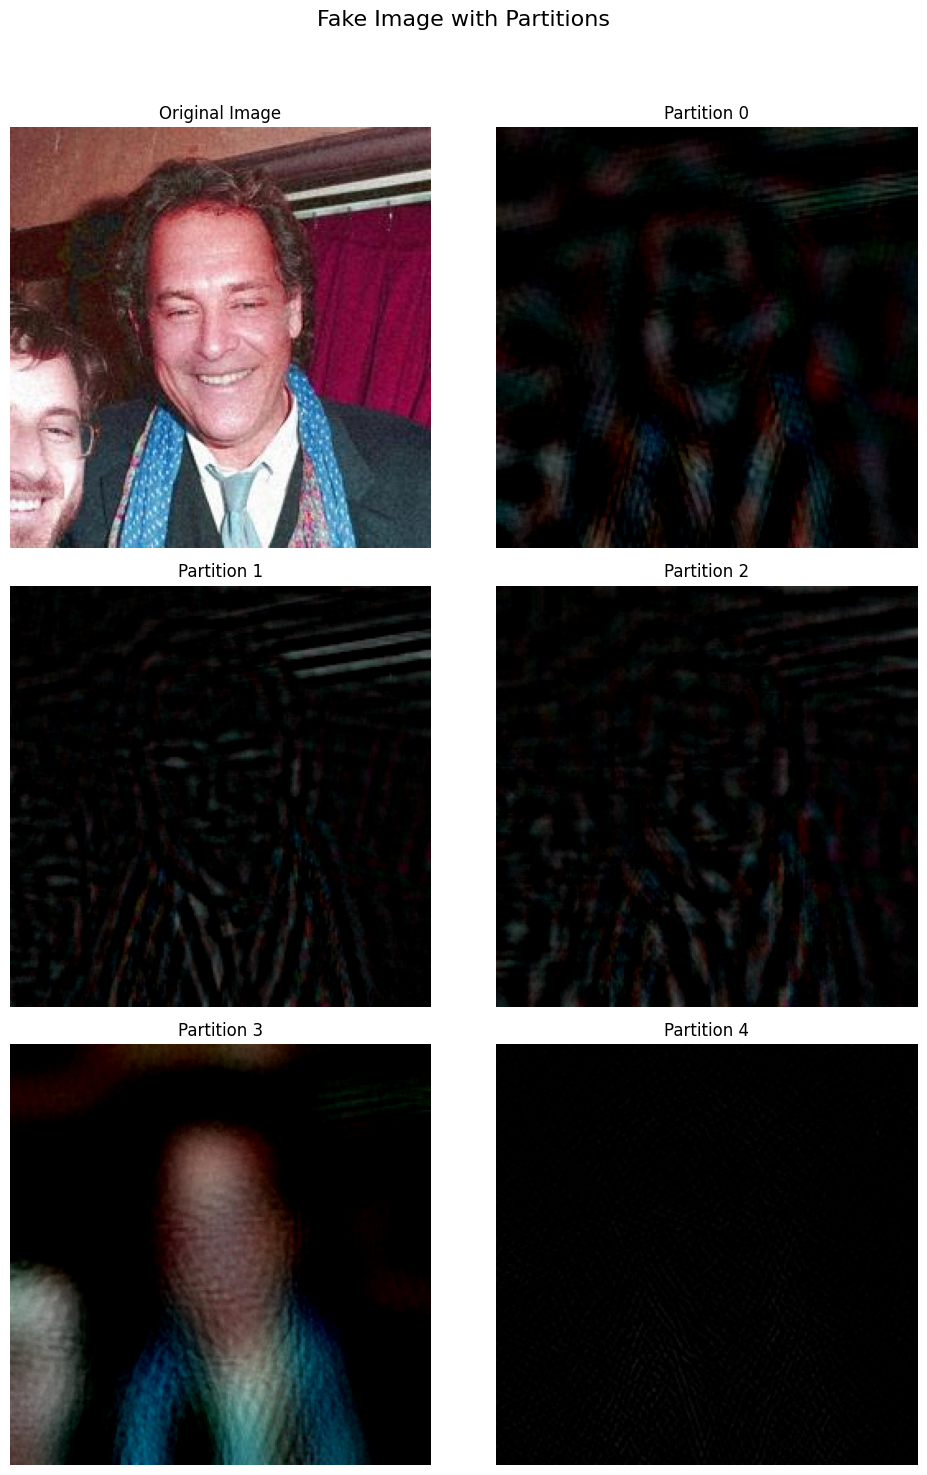

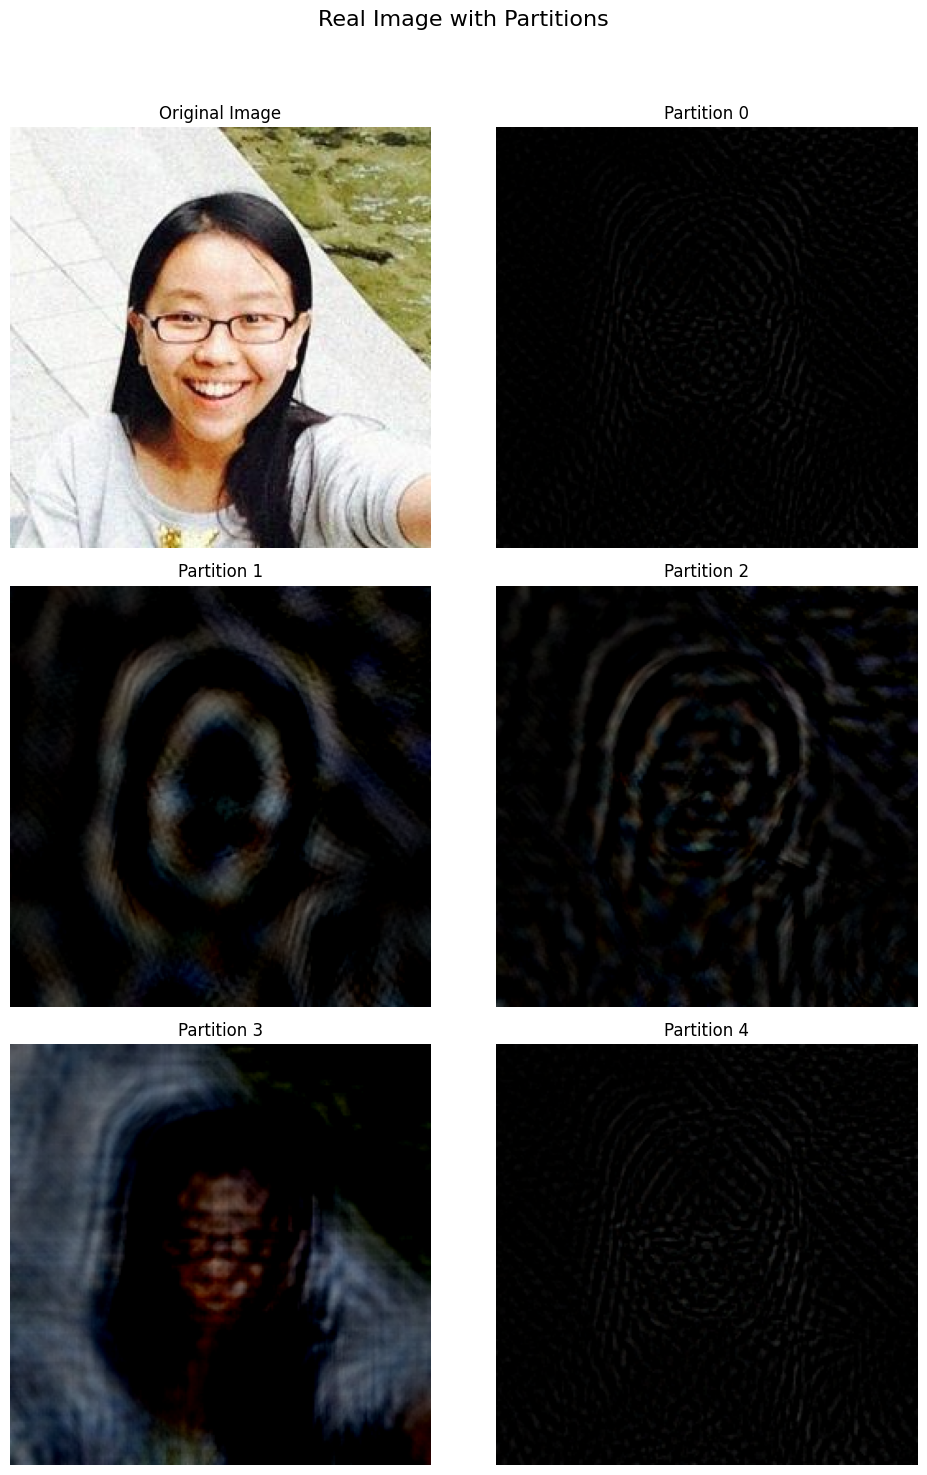

In [13]:
# Function to display partitions in one figure, including the original image
def display_partitions_with_original(image_path, partitions, title, num_columns=2):
    """
    Displays the original image and its partitions in a single figure.

    Args:
        image_path (str): Path to the original image.
        partitions (list): List of partitioned images.
        title (str): Title of the figure.
        num_columns (int): Number of columns for subplot arrangement.
    """
    # Load the original image
    original_image = Image.open(image_path)
    original_image_np = np.array(original_image)
    
    num_partitions = len(partitions)
    num_rows = (num_partitions + num_columns) // num_columns  # Add one row for the original image
    
    plt.figure(figsize=(num_columns * 5, num_rows * 5))  # Adjust figure size
    
    # Display the original image
    plt.subplot(num_rows, num_columns, 1)
    plt.imshow(original_image_np)
    plt.title("Original Image")
    plt.axis('off')

    # Display partitions
    for i, partition in enumerate(partitions, start=2):
        partition = np.clip(partition, 0, 255).astype(np.uint8)
        plt.subplot(num_rows, num_columns, i)
        plt.imshow(partition, cmap='gray')
        plt.title(f"Partition {i - 2}")
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Assuming `fake_image_path` and `real_image_path` are paths to the original images
fake_image_path = "Deepfake_Dataset/Test/Fake/fake_15.jpg"  # Replace with actual path
real_image_path = "Deepfake_Dataset/Test/Real/real_1170.jpg"  # Replace with actual path

# Display fake image and its partitions
display_partitions_with_original(fake_image_path, fake_partitions, "Fake Image with Partitions")

# Display real image and its partitions
display_partitions_with_original(real_image_path, real_partitions, "Real Image with Partitions")

## Ensemble Model

In [ ]:
ensemble_models = []
for i in range(NUM_ENSEMBLE_MODELS):
    model = util.dfnn_model.DeepfakeDetectorCNN(num_classes=2)
    model.load_state_dict(torch.load(model_save_path))
    model.to(device)
    model.eval()  # Set to eval mode
    ensemble_models.append(model)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Single Model

In [3]:
single_model = util.dfnn_model.DeepfakeDetectorCNN(num_classes=2)
single_model.load_state_dict(torch.load(model_save_path))
single_model.to(device)
single_model.eval()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepfakeDetectorCNN(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

## Comparing
Takes too long.

In [ ]:
def create_partitioned_dataloaders(path, subset):
    subset_path = os.path.join(path, subset)
    dataloaders = []
    for part_idx in range(NUM_ENSEMBLE_MODELS):
        part_dataset = util.load_data.get_subset(subset=f"Partition{part_idx + 1}", data_dir=subset_path, data_percentage=1)
        part_dataloader = util.load_data.load_dataset(part_dataset, shuffle=False)
        dataloaders.append(part_dataloader)
    return dataloaders
        
train_dataloaders = create_partitioned_dataloaders(saliency_partitioned_save_path, 'Train')
validation_dataloaders = create_partitioned_dataloaders(saliency_partitioned_save_path, 'Validation')
test_dataloaders = create_partitioned_dataloaders(saliency_partitioned_save_path, 'Test')

In [ ]:
for model, train_loader, validation_loader in zip(ensemble_models, train_dataloaders, validation_dataloaders):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    util.train_model.train_with_validation(model, train_loader, validation_loader, criterion, optimizer, device)

Epoch [1/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.24s/it]


Training Loss: 3.2177
Validation Loss: 1.0544, Validation Accuracy: 50.00%

Epoch [2/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.14s/it]


Training Loss: 0.6164
Validation Loss: 2.4579, Validation Accuracy: 49.18%

Epoch [3/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.13s/it]


Training Loss: 0.7670
Validation Loss: 0.9754, Validation Accuracy: 60.66%

Epoch [4/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.16s/it]


Training Loss: 0.7751
Validation Loss: 0.6993, Validation Accuracy: 50.82%

Epoch [5/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.12s/it]


Training Loss: 0.6988
Validation Loss: 0.6942, Validation Accuracy: 50.82%

Epoch [6/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.02s/it]


Training Loss: 0.7072
Validation Loss: 0.6913, Validation Accuracy: 50.00%

Epoch [7/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.26s/it]


Training Loss: 0.6902
Validation Loss: 0.6878, Validation Accuracy: 50.00%

Epoch [8/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.17s/it]


Training Loss: 0.7045
Validation Loss: 0.6912, Validation Accuracy: 49.18%

Epoch [9/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.09s/it]


Training Loss: 0.6907
Validation Loss: 0.6922, Validation Accuracy: 50.00%

Epoch [10/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.11s/it]


Training Loss: 0.6803
Validation Loss: 0.6933, Validation Accuracy: 50.00%

Epoch [1/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.22s/it]


Training Loss: 3.0919
Validation Loss: 0.6847, Validation Accuracy: 50.82%

Epoch [2/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.26s/it]


Training Loss: 0.6250
Validation Loss: 3.6229, Validation Accuracy: 50.00%

Epoch [3/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.10s/it]


Training Loss: 0.7977
Validation Loss: 1.1475, Validation Accuracy: 50.00%

Epoch [4/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.39s/it]


Training Loss: 0.7500
Validation Loss: 0.6879, Validation Accuracy: 57.38%

Epoch [5/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.16s/it]


Training Loss: 0.7069
Validation Loss: 0.6929, Validation Accuracy: 52.46%

Epoch [6/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.28s/it]


Training Loss: 0.6955
Validation Loss: 0.6935, Validation Accuracy: 45.90%

Epoch [7/10] - Training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:32<00:00,  2.29s/it]


Training Loss: 0.7033
Validation Loss: 0.6900, Validation Accuracy: 56.56%

Epoch [8/10] - Training:


 14%|███████████████▏                                                                                          | 2/14 [00:05<00:30,  2.56s/it]


KeyboardInterrupt: 